# Debugging OpenCL applications

Debugging OpenCL applications has traditionally been a difficult topic. However there are some tools and techniques to help. These tools are:

* Checking the error codes on every OpenCL call
* Checking memory access from within kernels
* Visual inspection of outputs
* Using **printf** within kernels
* Using **Oclgrind** to check memory access violations

We will introduce an intentional bug into our matrix multiplication program and see if we can find it. In this instance we intentionally remove the guard check that protects the kernel from running off the end of buffer **C**. We choose the size of matrices **A**, **B**, and **C** to be (72,72) and a local size of (4,16)

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_boundaries.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Running off the end of the array due to differences between array size and global size.</figcaption>
</figure>


```C++
// kernels_mat_mult_badmem.c source

// standard matrix multiply kernel 
__kernel void mat_mult (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(0); 
    size_t i1=get_global_id(1); 
    
    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    
    // Comment out the guard mechanism 
    // to make sure we do not go
    // outside the boundaries of matrix C 
    
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
} 
```

## Construct inputs

As before we construct the arrays for input.

In [8]:
import numpy as np

from matplotlib import pyplot as plt

%matplotlib widget

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

NCOLS_A = 72
NROWS_C = 72
NCOLS_C = 72

# Data type
dtype = np.float32

# Make up the arrays A, B, and C
A = np.random.random(size = (NROWS_C, NCOLS_A)).astype(dtype)
B = np.random.random(size = (NCOLS_A, NCOLS_C)).astype(dtype)

# Make up the answer
C = np.matmul(A, B, dtype = dtype)

# Write out the arrays as binary files
A.tofile("array_A.dat")
B.tofile("array_B.dat")

## Run the buggy application

In [13]:
!make clean; make; ./mat_mult_badmem.exe

rm -r *.exe
g++ -std=c++11 -g -O2 -fopenmp -I/usr/local/cuda/include -I../include -L/usr/local/cuda/lib64 mat_mult_badmem.cpp\
	-o mat_mult_badmem.exe -lOpenCL -lomp
In file included from ../include/cl_helper.hpp:10,
                 from mat_mult_badmem.cpp:16:
/usr/local/cuda/include/CL/cl.hpp:5085:28: warning: ignoring attributes on template argument ‘cl_int’ {aka ‘int’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
 5085 |         VECTOR_CLASS<cl_int>* binaryStatus = NULL,
      |                            ^
In file included from mat_mult_badmem.cpp:16:
../include/cl_helper.hpp:16:29: warning: ignoring attributes on template argument ‘cl_int’ {aka ‘int’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
   16 | std::map<cl_int, const char*> error_codes {
      |                             ^
g++ -std=c++11 -g -O2 -fopenmp -I/usr/local/cuda/include

Notice that with some OpenCL implementations the code completes without crashing. This is because some GPU-based opencl frameworks do not have accurate memory access violation checks. Thus small memory access violations result in undefined behaviour. CPU implementations are sensitive memory access violation checks and are more susceptible to memory access bugs than others.

## Visual inspection of outputs

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
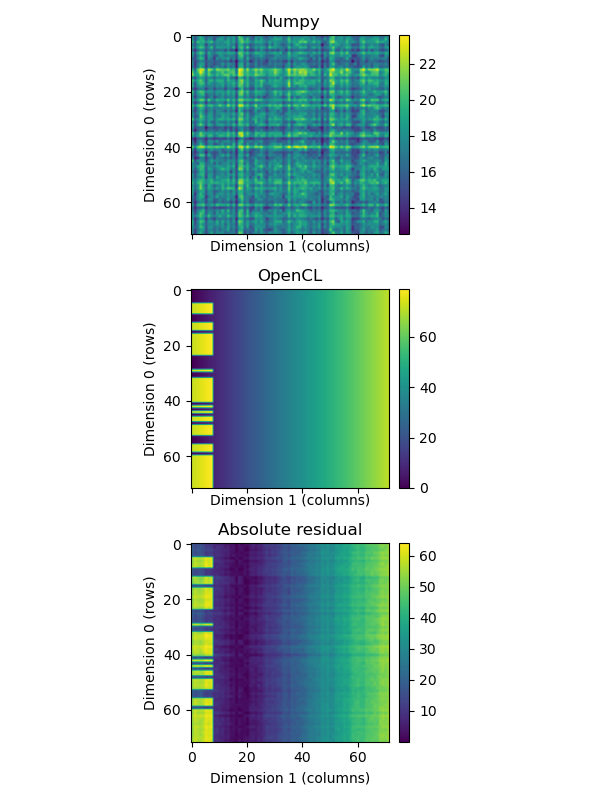

In [16]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()

Running off the end of the array is obvious in this instance because it affects the next row. That is why 8 cells are affected on the left hand side of the array.

## Checking memory access

When trying to get your OpenCL codes working it is helpful to first make sure that your memory accesses are valid. In this instance we change the kernel to [kernels_mat_mult_memcheck.c](kernels_mat_mult_memcheck.c) so that it puts into **C** the value of i1. Run the code and check the results by running the visual check above.

In [15]:
!make; ./mat_mult_memcheck.exe

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12636 MB
	    max buffer size: 3159 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024


## Debugging with **printf**

Some OpenCL implementations, in particular CPU ones, allow the use of a **printf** statement within a kernel.

## Debugging with GDB

## Debugging and validation with OCLGrind

In [50]:
!oclgrind ./mat_mult_badmem.exe

	               name: Oclgrind Simulator 
	 global memory size: 134 MB
	    max buffer size: 134 MB
	     max local size: (1024,1024,1024)
	     max work-items: 1024

Invalid read of size 4 at global memory address 0x1000000005100
	Kernel: mat_mult
	Entity: Global(72,0,0) Local(8,0,0) Group(4,0,0)
	  %0 = load float, float addrspace(1)* %arrayidx, align 4, !dbg !54, !tbaa !47
	At line 32 (column 19) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x1000000005104
	Kernel: mat_mult
	Entity: Global(72,0,0) Local(8,0,0) Group(4,0,0)
	  %0 = load float, float addrspace(1)* %arrayidx, align 4, !dbg !54, !tbaa !47
	At line 32 (column 19) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x1000000005108
	Kernel: mat_mult
	Entity: Global(72,0,0) Local(8,0,0) Group(4,0,0)
	  %0 = load float, float addrspace(1)* %arrayidx, align 4, !dbg !54, !tbaa !47
	At line 32 (column 19) of input.cl:
	  tem

## Exercise